### Extract the dataset and split accordingly

- Unzip the dataset
- Split the dataset into train, validation and test sets
- From the metadata build the train, validation and test images and labels folders
- Load the Images from directory

In [1]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import helper_funcs as helper
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from pathlib import Path


import warnings
warnings.filterwarnings('ignore')

# model analysis and development
import edgeimpulse as ei
from livelossplot import PlotLossesKeras 

# Import the necessary callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from livelossplot.outputs import MatplotlibPlot
from plot_keras_history import  plot_history
from sklearn.metrics import classification_report

# inferencing
from PIL import Image

# Set random seed for reproducibility
random_state = 42
tf.random.set_seed(random_state)
random.seed(random_state)

In [ ]:
# Extract the dataset to the current working directory
with zipfile.ZipFile('./dataset.zip', 'r') as zip:
    zip.extractall(f'{os.getcwd()}')

In [2]:
# load the train and test metadata
data_dir = os.path.join(os.getcwd(), 'dataset')
train_metadata_path = os.path.join(data_dir, 'train.csv')
test_metadata_path = os.path.join(data_dir, 'test.csv')

# read the data
train_df = pd.read_csv(train_metadata_path)
test_df = pd.read_csv(test_metadata_path)

# split the train set to train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# the length of all the sets
sets_len = len(train_df) + len(val_df) + len(test_df)

# print the length of each set
print(f'Train set length: {len(train_df)}, {len(train_df)/sets_len*100:.2f}%')
print(f'Validation set length: {len(val_df)}, {len(val_df)/sets_len*100:.2f}%')
print(f'Test set length: {len(test_df)}, {len(test_df)/sets_len*100:.2f}%')

Train set length: 1668, 71.83%
Validation set length: 418, 18.00%
Test set length: 236, 10.16%


In [ ]:
# build the image datasets
train_dir = os.path.join(data_dir, 'train') # location of the training data
val_dir = os.path.join(data_dir, 'train') # location of the validation data
test_dir = os.path.join(data_dir, 'test') # location of the test data

# create the training, validation and test directories
helper.split_data(train_dir, train_df, 'train')
helper.split_data(val_dir, val_df, 'val')
helper.split_data(test_dir, test_df, 'test')

In [2]:
# load the images to tensors 
train_images_path = 'train'
val_images_path = 'val'
test_images_path = 'test'

train_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'train',
                                                                    image_size=(96, 96),
                                                                    batch_size=3,
                                                                    shuffle=True,
                                                                    seed=random_state
                                                                )
val_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'val',
                                                                    image_size=(96, 96),
                                                                    batch_size=3,
                                                                    seed=random_state
                                                                )
test_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'test',
                                                                    image_size=(96, 96),
                                                                    batch_size=3,
                                                                    seed=random_state,
                                                                    shuffle=False
                                                                )

# extract the train images and labels
train_images, train_labels = helper.extract_images_and_labels(train_tensors, normalize=True, categorical=True)

# extract the validation images and labels
val_images, val_labels = helper.extract_images_and_labels(val_tensors, normalize=True, categorical=True)

# extract the test images and labels
test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=True)

# Define the labels dictionary
labels = {
    0: 'BUSHBUCK',
    1: 'IMPALA',
    2: 'MONKEY',
    3: 'WARTHOG',
    4: 'WATERBUCK',
    5: 'ZEBRA'
}



Found 1668 files belonging to 6 classes.
Found 418 files belonging to 6 classes.
Found 236 files belonging to 6 classes.


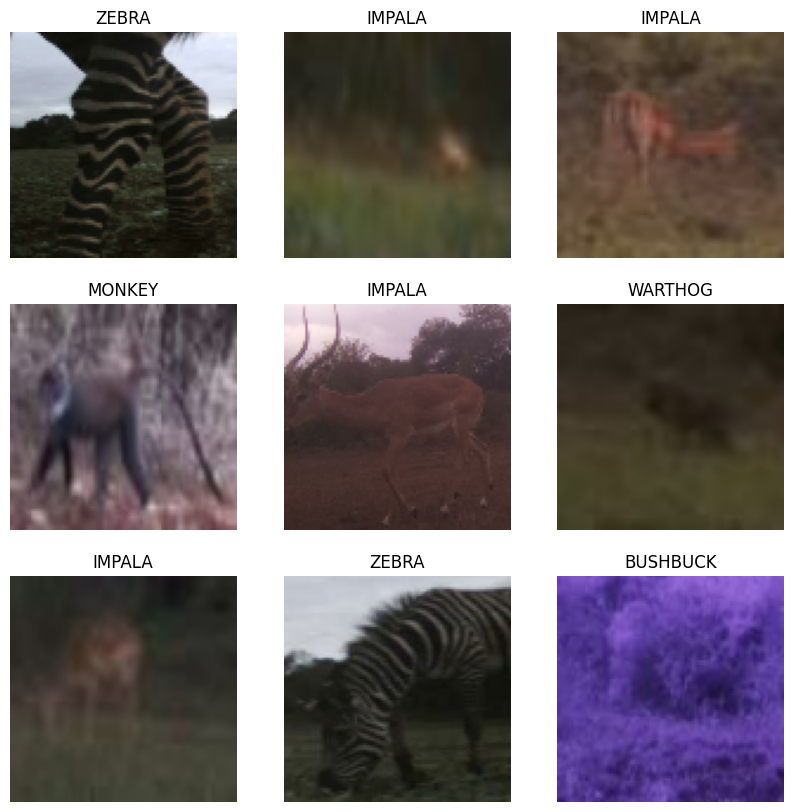

In [46]:
helper.visualize_images(train_tensors, 9)

In [47]:
helper.data_distribution(train_images_path, val_images_path, test_images_path, plot=False)

({'BUSHBUCK': 153,
  'IMPALA': 628,
  'MONKEY': 14,
  'WARTHOG': 484,
  'WATERBUCK': 264,
  'ZEBRA': 125},
 {'BUSHBUCK': 31,
  'IMPALA': 186,
  'MONKEY': 8,
  'WARTHOG': 101,
  'WATERBUCK': 61,
  'ZEBRA': 31},
 {'BUSHBUCK': 21,
  'IMPALA': 91,
  'MONKEY': 3,
  'WARTHOG': 66,
  'WATERBUCK': 37,
  'ZEBRA': 18})

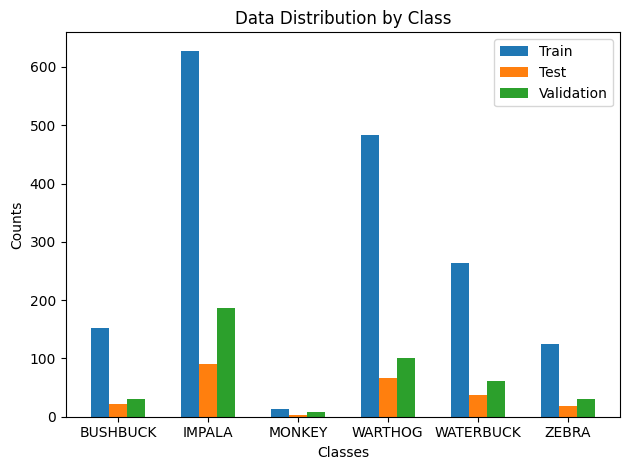

In [48]:
helper.data_distribution(train_images_path, val_images_path, test_images_path, plot=True)

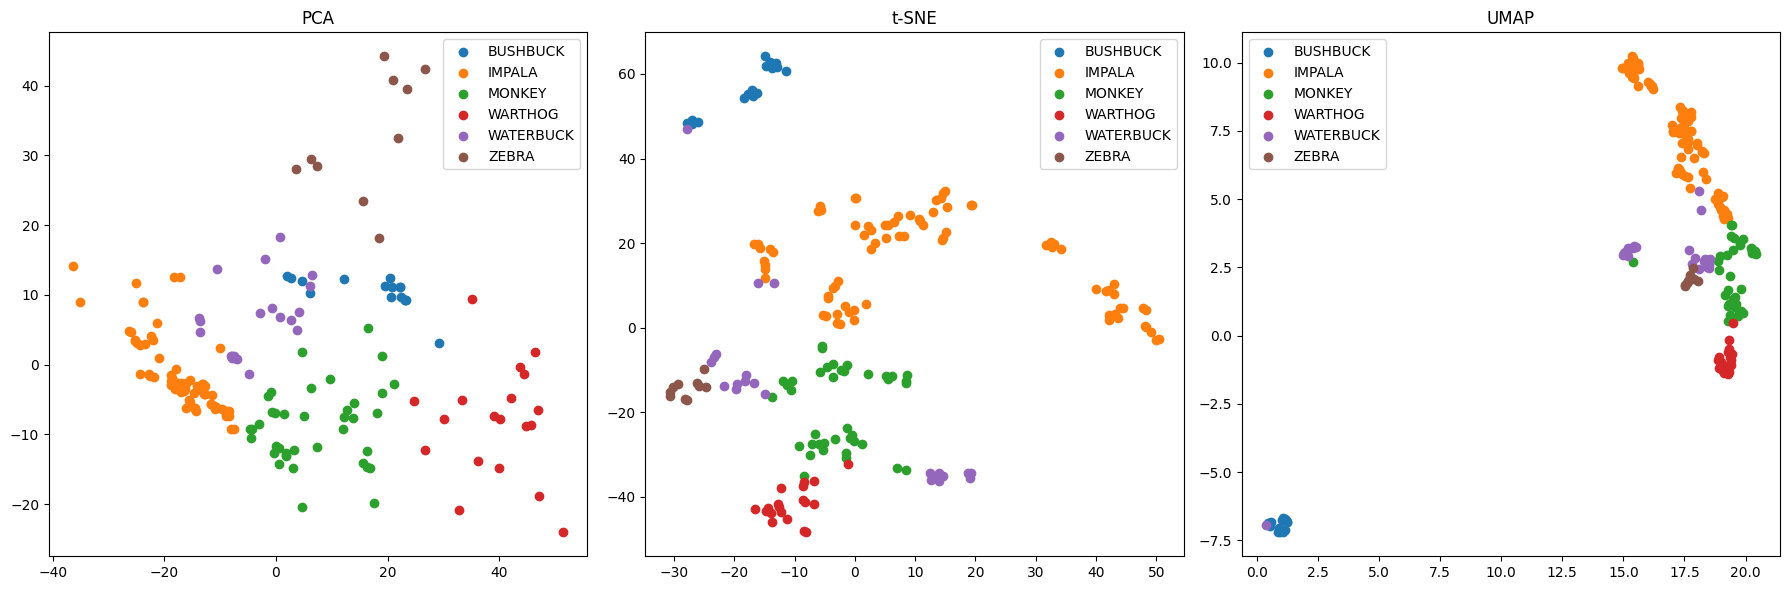

In [21]:
# Call the function with your train_images, train_labels, and labels
helper.visualize_dimensionality_reduction(train_images, train_labels, labels)


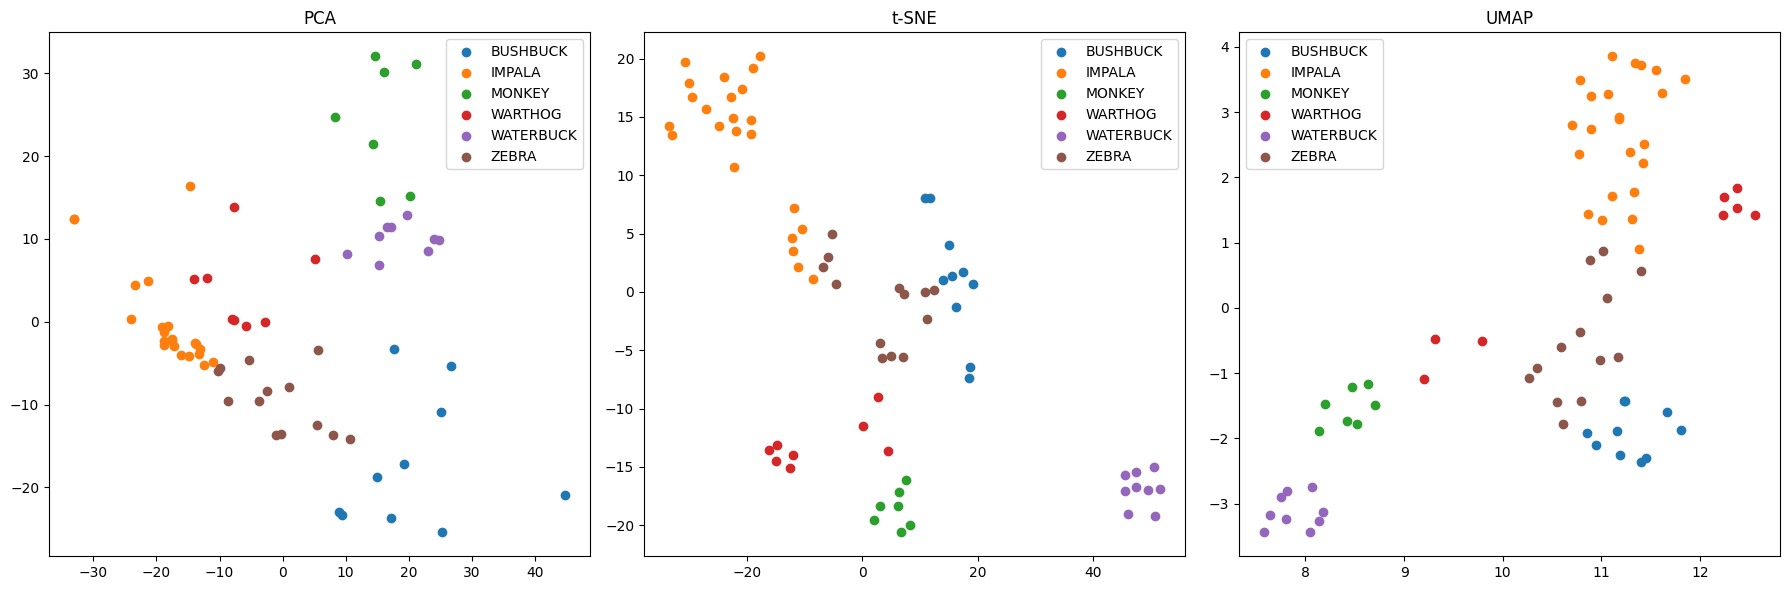

In [4]:
helper.visualize_dimensionality_reduction(val_images, val_labels, labels)


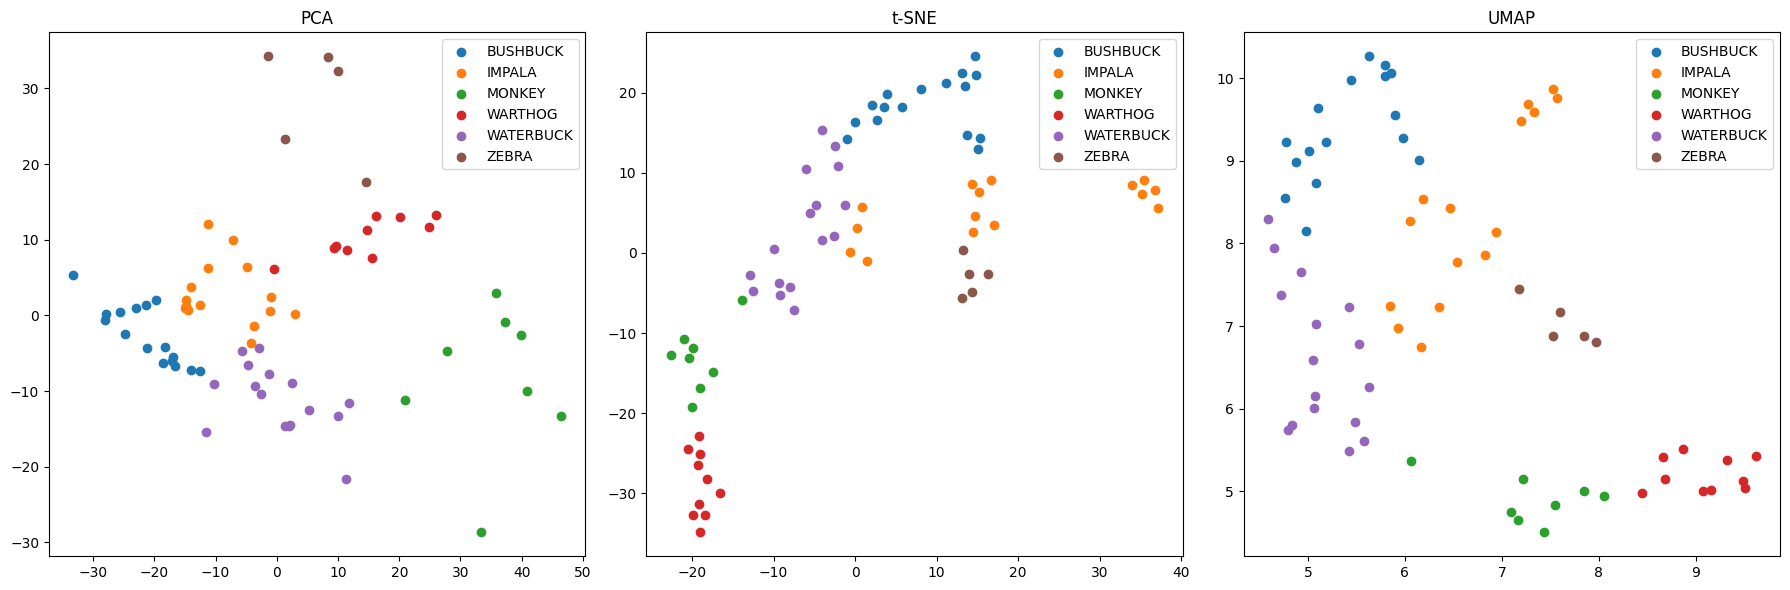

In [105]:
helper.visualize_dimensionality_reduction(val_images, val_labels, labels)


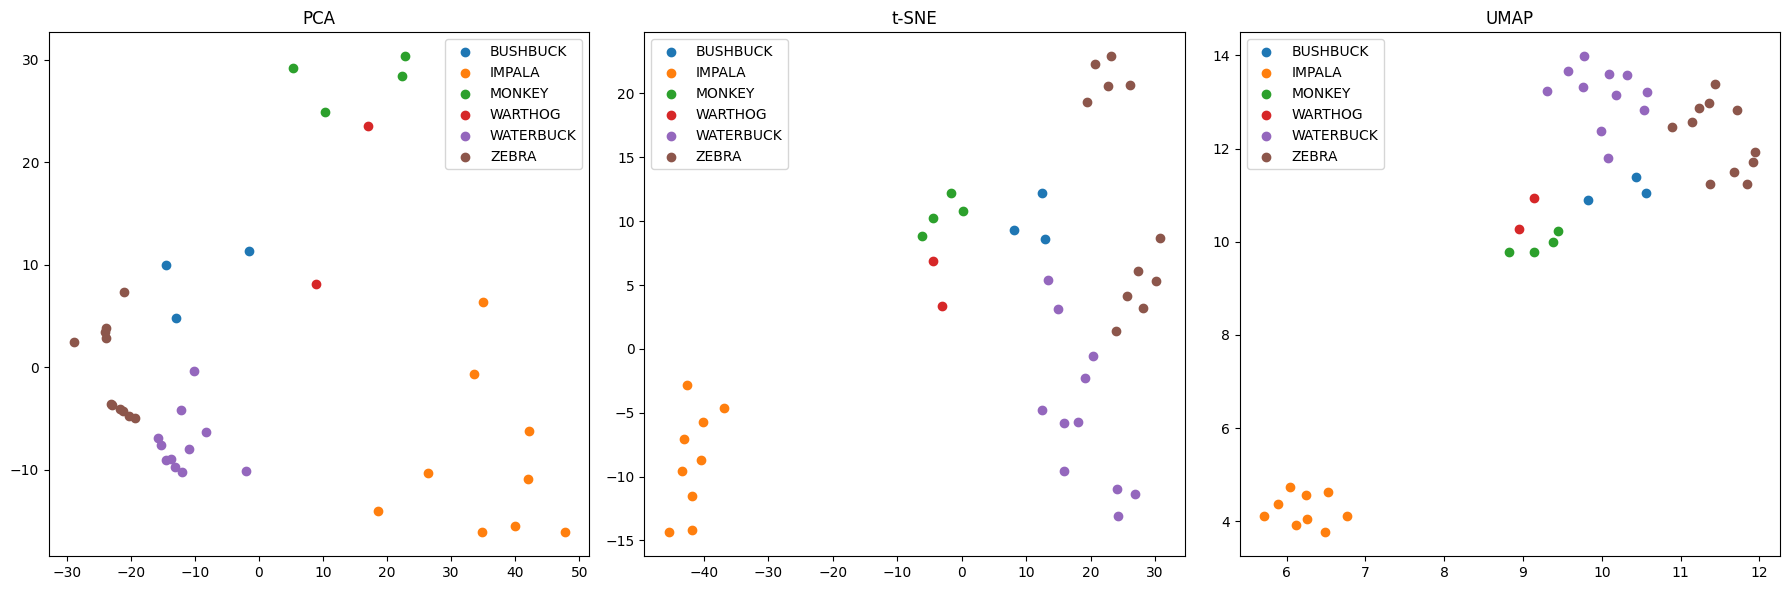

In [4]:
helper.visualize_dimensionality_reduction(test_images, test_labels, labels)


### Model Development

In [189]:
# Model Architecture leveraging pretrained weights

EPOCHS = 100
LEARNING_RATE = 0.005
NUM_CLASSES = 6
DROPOUT = 0.05
WEIGHT_DECAY = 0.000
ACTIVATION = 'softmax'
OPTIMIZER = 'adam'
MOMENTUM = 0.5

model = helper.build_model(num_classes=NUM_CLASSES, dropout=DROPOUT, 
                   weight_decay=WEIGHT_DECAY, activation=ACTIVATION, 
                   optimizer=OPTIMIZER, momentum=MOMENTUM,
                   learning_rate=LEARNING_RATE)

#### Defining Callbacks

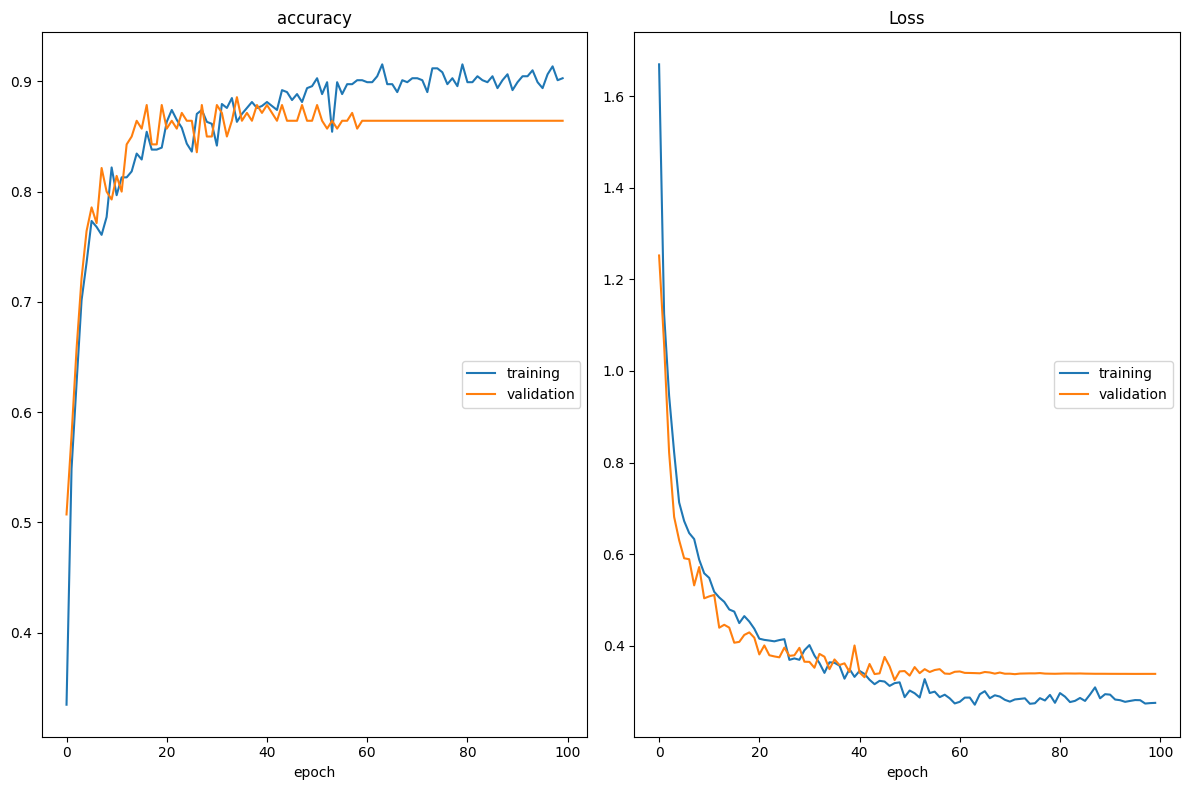

18/18 - 1s - loss: 0.2750 - accuracy: 0.9029 - val_loss: 0.3384 - val_accuracy: 0.8643 - lr: 2.4414e-06 - 1s/epoch - 76ms/step


In [190]:
filepath = 'mobileweights_6classes3.h5'
anim = PlotLossesKeras(outputs=[MatplotlibPlot()])

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                save_best_only=True, mode='min', 
                                                verbose=2)

# Define the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                 patience=5, verbose=1, min_lr=1e-6)

# Include the lr_scheduler callback in the list of callbacks
callbacks = [checkpoint, anim, lr_scheduler]

# Train the model
history = model.fit(
                  train_images,
                  train_labels,
                  epochs=EPOCHS,
                  validation_data=(val_images, val_labels),
                  verbose=2,
                  callbacks=callbacks
                )


## Model Evaluation

(<Figure size 4500x1500 with 3 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

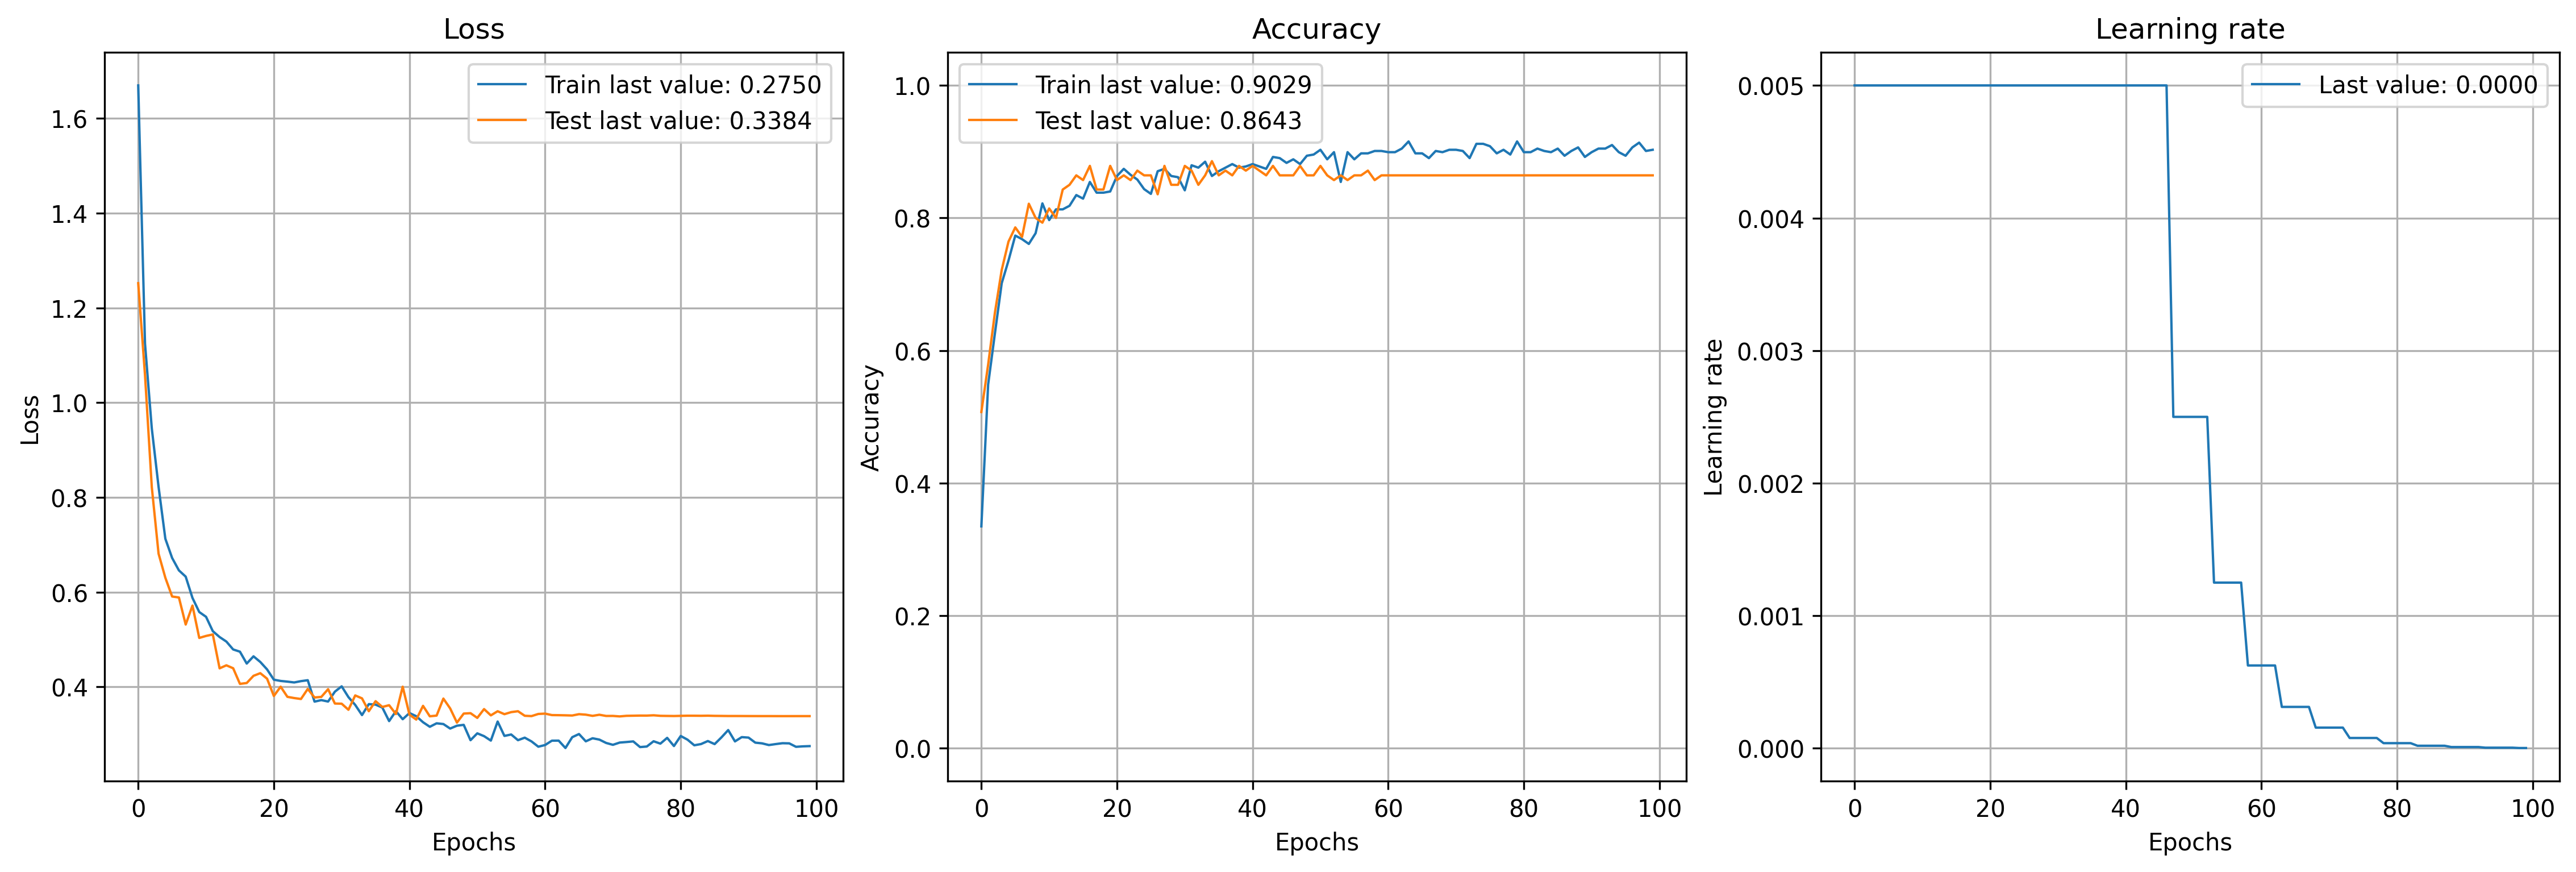

In [191]:
plot_history(history, dpi=300)

In [192]:
model = tf.keras.models.load_model('mobileweights_6classes3.h5')

model.evaluate(test_images, test_labels)

3/3 [==============================] - 1s 44ms/step - loss: 0.9615 - accuracy: 0.6962


[0.9614554047584534, 0.6962025165557861]

In [22]:
from sklearn.metrics import classification_report

test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=False)
y_pred = model.predict(test_images, batch_size=6, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

2/2 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.25      0.50      0.33         2
           3       1.00      0.75      0.86         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.44         9
   macro avg       0.25      0.25      0.24         9
weighted avg       0.50      0.44      0.46         9



3/3 [==============================] - 1s 32ms/step
Class: 0
Class: 1
Class: 2
Class: 3
Class: 4
Class: 5


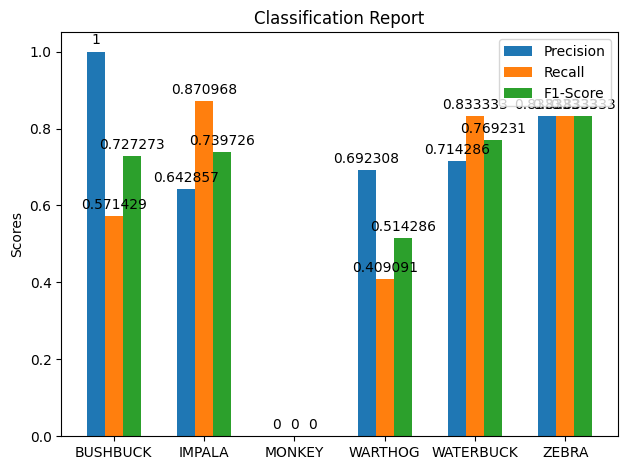

In [194]:
model = tf.keras.models.load_model('mobileweights_6classes3.h5')

helper.plot_classification_report(model, test_tensors)

#### Inferencing

Class: ZEBRA
1/1 [==============================] - 0s 44ms/step


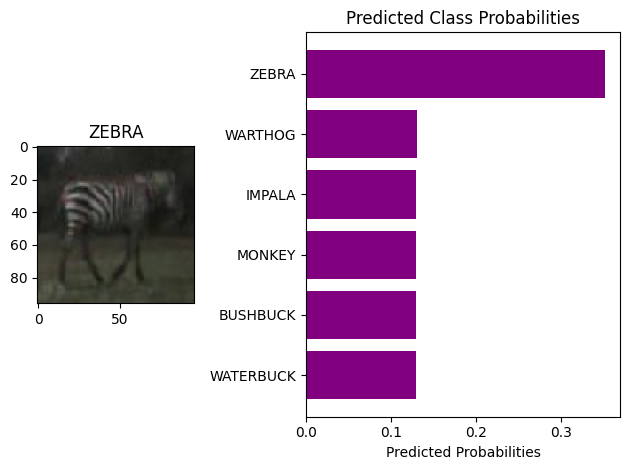

In [13]:

# model = tf.keras.models.load_model('mobileweights_6classes3.h5')

helper.inference_model(model)

Class: ZEBRA
1/1 [==============================] - 1s 1s/step


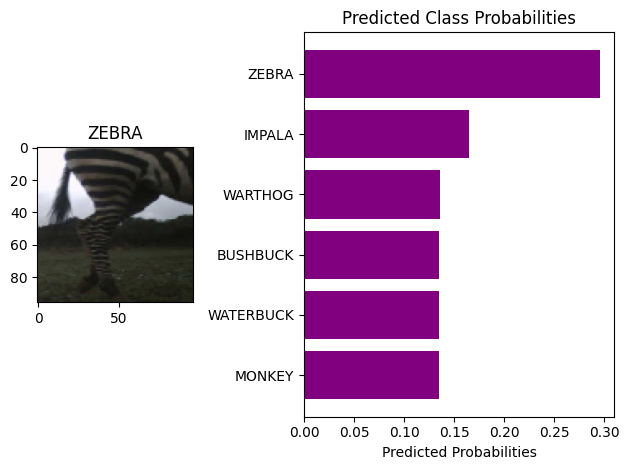

In [3]:

model = tf.keras.models.load_model('mobileweights_6classes.h5')

helper.inference_model(model)

## Model Quantization

In [255]:
def representative_dataset_generator():
    for data, _ in val_tensors.take(-1):
        yield [data]  # shape: (batch_size, height, width, channels)


# load the best model
model = tf.keras.models.load_model('mobileweights_6classes3.h5')

# quantizing the model to int8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_generator
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.target_spec.supported_types = [tf.dtypes.float16]
converter.inference_input_type = tf.float16
converter.inference_output_type = tf.float16

hub_m = converter.convert()

# save the keras model
with open('mobileweights_6classes4.tflite', 'wb') as f:
    f.write(hub_m)  

INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpcifd2igg\assets


INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpcifd2igg\assets


ValueError: The inference_input_type and inference_output_type must be tf.float32.

### Profiling and Evaluating the Model
- Evaluating the quantized int8 tflite model  
- Profiling the model to check compatibility with the MCU

In [158]:
import edgeimpulse as ei
# add the api key to edge impulse
with open('config.json') as f:
    config = json.load(f)


api_key = config['edge_impulse_api_key']
ei.API_KEY = api_key
    
# the supported devices
profile_devices = ei.model.list_profile_devices()
print(profile_devices)

# target device is open mv cam h7 plus
model_profile = ei.model.profile(model=hub_m, device='arduino-nano-33-ble')

['alif-he', 'alif-hp', 'arduino-nano-33-ble', 'arduino-nicla-vision', 'portenta-h7', 'brainchip-akd1000', 'cortex-m4f-80mhz', 'cortex-m7-216mhz', 'espressif-esp32', 'himax-we-i', 'infineon-cy8ckit-062s2', 'infineon-cy8ckit-062-ble', 'jetson-nano', 'mbp-16-2020', 'memryx-mx3', 'nordic-nrf52840-dk', 'nordic-nrf5340-dk', 'nordic-nrf9160-dk', 'raspberry-pi-4', 'raspberry-pi-rp2040', 'renesas-ck-ra6m5', 'renesas-rzv2l-cpu', 'renesas-rzv2l', 'st-iot-discovery-kit', 'seeed-sense-cap', 'wio-terminal', 'seeed-vision-ai', 'silabs-xg24', 'silabs-thunderboard-sense-2', 'sony-spresense', 'synaptics-ka10000', 'ti-am62a', 'ti-am68a', 'ti-launchxl', 'ti-tda4vm']


In [165]:
# Profiling the model to check the compatibility with the MCU
model_profile.summary()

Target results for int8:
{
    "device": "arduino-nano-33-ble",
    "tfliteFileSizeBytes": 217376,
    "isSupportedOnMcu": true,
    "memory": {
        "tflite": {
            "ram": 101216,
            "rom": 281656,
            "arenaSize": 100864
        },
        "eon": {
            "ram": 103440,
            "rom": 230424
        }
    },
    "timePerInferenceMs": 817
}


Performance on device types:
{
    "variant": "int8",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 6099,
        "memory": {
            "tflite": {
                "ram": 100435,
                "rom": 267192
            },
            "eon": {
                "ram": 81856,
                "rom": 217496
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInferenceMs": 126,
        "memory":

## Model Deployment

In [ ]:
# generating an output file for arduino-nano-33-ble-sense
print('Buuilding firmaware for arduino-nano-33-ble-sense target...')
ei.model.deploy(model='mobileweights_6classes2.tflite',
                model_output_type=ei.model.output_type.Classification(),
                model_input_type=ei.model.input_type.ImageInput(),
                deploy_target='arduino-nano-33-ble-sense',
                output_directory=".",
                api_key=api_key)

In [210]:
# Write the class names to text file
with open('labels.txt', 'w') as f:
    for item in list(train_tensors.class_names):
        f.write("%s\n" % item)

In [ ]:
# create a folder called openmv-model if it doesn't exist
# move the tflite file and labels.txt file into the openmv-model folder

os.rename('mobileweights_6classes3.tflite', 'openmv-model/trained445.tflite')

'''Uncomment and run this once if the file does not exist'''
# os.rename('labels.txt', 'openmv-model/labels.txt')

In [19]:
# evaluate the performance of the tflite model
helper.evaluate_tflite('openmv-model/trained445.tflite', test_tensors, dtype='int8')

0.0759493670886076